In [ ]:
##### Copyright 2021 The Cirq Developers

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Comparing current processor performance to the latest calibration data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/tutorials/google/compare_to_calibration"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/tutorials/google/compare_to_calibration.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/tutorials/google/compare_to_calibration.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/tutorials/google/compare_to_calibration.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

[Calibration](./visualizing_calibration_metrics.ipynb) runs at periodic intervals, but processor performances changes over time. How does the current state of a processor compare to the latest calibration data? This tutorial shows how to run [parallel XEB](../../qcvv/parallel_xeb.ipynb) and compare current two-qubit gate errors to the most recent calibration report.

**Disclaimer**: The data shown in this tutorial is exemplary and not representative of the QCS in production.

## Setup

First, we install Cirq and import the packages we will use.

Note: this notebook relies on unreleased Cirq features. If you want to try these features, make sure you install cirq via `pip install cirq --pre`.

In [ ]:
try:
    import cirq
except ImportError:
    !pip install --quiet cirq --pre

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import cirq
import cirq_google as cg

Next, we authorize to use the Quantum Computing Service.

In [ ]:
# The Google Cloud Project id to use.
project_id = '' #@param {type:"string"}
processor_id = "" #@param {type:"string"}

from cirq_google.engine.qcs_notebook import get_qcs_objects_for_notebook
device_sampler = get_qcs_objects_for_notebook(project_id, processor_id)


Getting OAuth2 credentials.
Press enter after entering the verification code.
Authentication complete.
Successful authentication to Google Cloud.


Now, we select a processor and visualize a two-qubit gate calibration metric. See the [Visualizing calibration metrics tutorial](./visualizing_calibration_metrics) for more background.

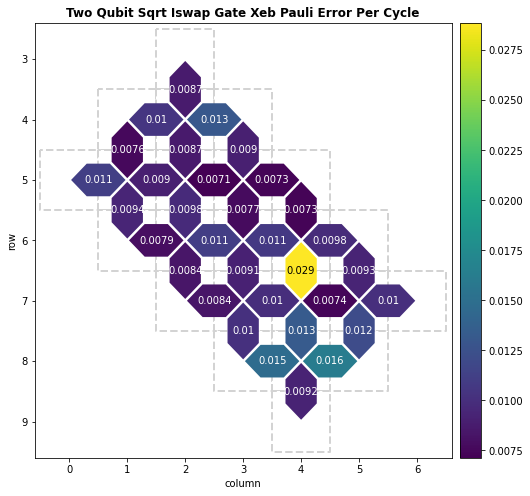

In [ ]:
processor_id = "" #@param {type:"string"}
calibration = cg.get_engine_calibration(processor_id=processor_id)
metric = "two_qubit_sqrt_iswap_gate_xeb_pauli_error_per_cycle"

calibration.heatmap(metric).plot();

## Parallel XEB

After viewing the latest calibration data, we now run [parallel XEB](../../qcvv/parallel_xeb.ipynb) on a set of qubits on the processor. Note that you can select a subset of qubits on the device which will shorten the runtime of the experiment.

In [ ]:
"""Select qubits to run parallel XEB on."""
qubits = cg.get_engine_device(processor_id).qubit_set()

In [ ]:
"""Setup for parallel XEB experiment."""
from cirq.experiments import random_quantum_circuit_generation as rqcg
import cirq.contrib.routing as ccr

# Generate library of XEB circuits.
circuit_library = rqcg.generate_library_of_2q_circuits(
    n_library_circuits=20, 
    two_qubit_gate=cirq.SQRT_ISWAP,
    random_state=52,
)
combs_by_layer = rqcg.get_random_combinations_for_device(
    n_library_circuits=len(circuit_library),
    n_combinations=10,
    device_graph=ccr.gridqubits_to_graph_device(sorted(qubits)),
    random_state=53,
)
cycle_depths = np.arange(3, 100, 20)

In [ ]:
"""Collect all data by executing circuits."""
from cirq.experiments.xeb_sampling import sample_2q_xeb_circuits
from cirq.experiments.xeb_fitting import benchmark_2q_xeb_fidelities, fit_exponential_decays

sampler = cg.get_engine_sampler(
    project_id=project_id,
    processor_id=processor_id,
    gate_set_name="sqrt_iswap",
)

# Run XEB circuits on the processor.
sampled_df = sample_2q_xeb_circuits(
    sampler=sampler,
    circuits=circuit_library,
    cycle_depths=cycle_depths,
    combinations_by_layer=combs_by_layer,
    shuffle=np.random.RandomState(52),
)

# Run XEB circuits on a simulator and fit exponential decays.
fids = benchmark_2q_xeb_fidelities(
    sampled_df=sampled_df,
    circuits=circuit_library,
    cycle_depths=cycle_depths,
)
fidelities = fit_exponential_decays(fids)

100%|██████████| 207/207 [22:55<00:00,  6.65s/it]


We can visualize these results on a `cirq.TwoQubitInteractionHeatmap` as follows.

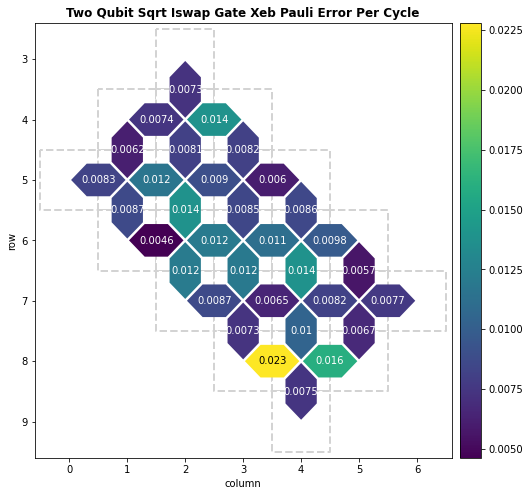

In [ ]:
"""Grab (pair, sqrt_iswap_pauli_error_per_cycle) data for all qubit pairs."""
pxeb_results = {
    pair: (1.0 - fidelity) / (4 / 3)
    for (_, _, pair), fidelity in fidelities.layer_fid.items()
}

cirq.TwoQubitInteractionHeatmap(pxeb_results).plot(
    title=metric.replace("_", " ").title()
);

Note: The parallel XEB errors are scaled in the previous cell. See the [XEB theory tutorial](https://quantumai.google/cirq/qcvv/xeb_theory#fidelities) for an explanation why.

## Side by side comparison

To make it easy to compare, we plot both heatmaps side by side on the same color scale.

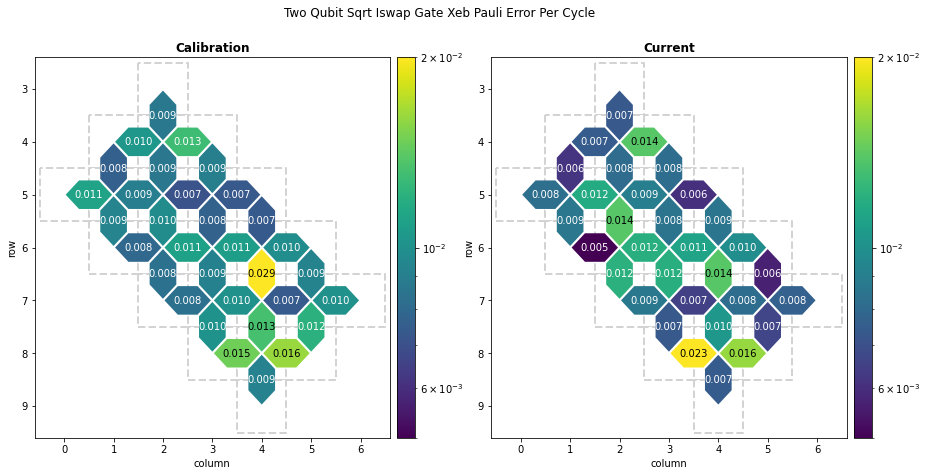

In [ ]:
from matplotlib.colors import LogNorm

# Plot options.
vmin = 5e-3
vmax = 2e-2
options = {"norm": LogNorm()}
format = "0.3f"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
fig.suptitle(metric.replace("_", " ").title())

calibration.heatmap(metric).plot(
    ax=axes[0], title="Calibration", vmin=vmin, vmax=vmax, 
    collection_options=options, annotation_format=format,
)
cirq.TwoQubitInteractionHeatmap(pxeb_results).plot(
    ax=axes[1], title="Current", vmin=vmin, vmax=vmax, 
    collection_options=options, annotation_format=format,
);

We can now inspect these heatmaps to directly compare current processor performance to the latest calibration data.